In [1]:
!ls 

__pycache__		   velovi_pancreas_noproc.ipynb
data			   velovi_pancreas_old.ipynb
velovi_adapted_metrics.py  velovi_pancreas_proc.ipynb
velovi_adapted_plots.py    velovi_script.py
velovi_adapted_utils.py


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI
import matplotlib.pyplot as plt
import seaborn as sns
from velovi_adapted_utils import load_files

In [3]:
adata_path = "../../outputs/final_anndatas/pancreas/miVelo.h5ad"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [03:04<00:00,  2.79it/s, v_num=1, train_loss_step=-6.17e+3, train_loss_epoch=-6.17e+3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [03:04<00:00,  2.70it/s, v_num=1, train_loss_step=-6.17e+3, train_loss_epoch=-6.17e+3]
computing velocity graph (using 1/24 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


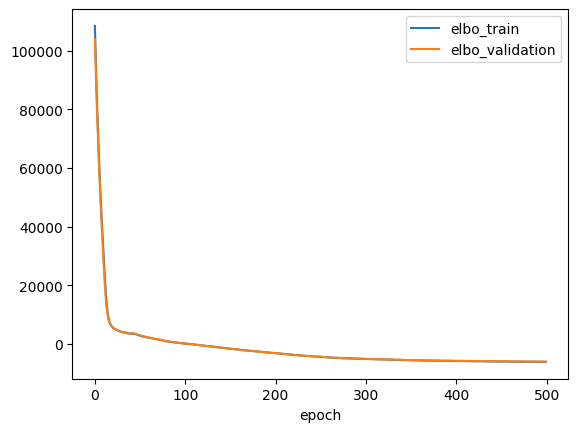

INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/mnt/data2/home/leonardo/miniconda3/envs/velovi/lib/python3.12/site-packages/velovi/__init__.py:7: UserWarning: The velovi package is no longer being actively developed or maintained as of v0.4.0. Please use the implementation in the scvi-tools package instead. For more information, see https://github.com/scverse/scvi-tools/issues/2610.
  warnings.warn(
/mnt/data2/home/leonardo/miniconda3/envs/velovi/lib/python3.12/site-packages/velovi/__init__.py:7: UserWarning: The velovi package is no longer being actively developed or maintained as of v0.4.0. Please use the implementation in the scvi-tools package instead. For more information, see https://github.com/scverse/scvi-tools/issues/2610.
  warnings.warn(
/mnt/data2/home/leonardo/miniconda3/envs/velovi/lib/python3.12/site-packages/velovi/__init__.py:7: UserWarning: The velovi package is no longer being actively developed or maintained as of v0.4.0. Please use the

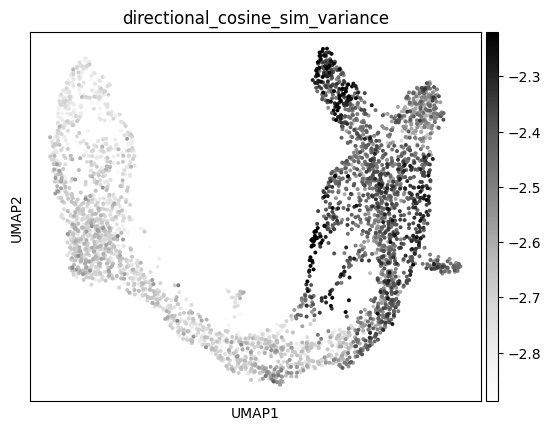

Working...: 100%|██████████| 25/25 [00:41<00:00,  1.65s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3376 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    2.0s finished


In [4]:
adata = sc.read_h5ad(adata_path)
sc.pp.neighbors(adata)
#adata = preprocess_data(adata)
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()
fig, ax = plt.subplots()
vae.history["elbo_train"].iloc[:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[:].plot(ax=ax, label="validation")
plt.legend()
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")
    velocities_u = vae.get_velocity(n_samples=25, velo_statistic="mean", velo_mode="unspliced")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["velocity_u"] = velocities_u / scaling
    adata.layers["latent_time_velovi"] = latent_time
    adata.obsm["z"] = vae.get_latent_representation(adata)

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    scaling = np.array(scaling)
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap')
uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=100)
uncertainty_df.head()
for c in uncertainty_df.columns:
    adata.obs[c] = np.log10(uncertainty_df[c].values)
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance",
    cmap="Greys",
    vmin="p1",
    vmax="p99",
)

def compute_extrinisic_uncertainty(adata, vae, n_samples=25) -> pd.DataFrame:
    from velovi._model import _compute_directional_statistics_tensor
    from scvi.utils import track
    from contextlib import redirect_stdout
    import io

    extrapolated_cells_list = []
    for i in track(range(n_samples)):
        with io.StringIO() as buf, redirect_stdout(buf):
            vkey = "velocities_velovi_{i}".format(i=i)
            v = vae.get_velocity(n_samples=1, velo_statistic="mean")
            adata.layers[vkey] = v
            scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=False, approx=True)
            t_mat = scv.utils.get_transition_matrix(
                adata, vkey=vkey, self_transitions=True, use_negative_cosines=True
            )
            extrapolated_cells = np.asarray(t_mat @ adata.layers["Ms"])
            extrapolated_cells_list.append(extrapolated_cells)
    extrapolated_cells = np.stack(extrapolated_cells_list)
    df, _ = _compute_directional_statistics_tensor(extrapolated_cells, n_jobs=-1, n_cells=adata.n_obs)
    return df

ext_uncertainty_df = compute_extrinisic_uncertainty(adata, vae)
for c in ext_uncertainty_df.columns:
    adata.obs[c + "_extrinisic"] = np.log10(ext_uncertainty_df[c].values)

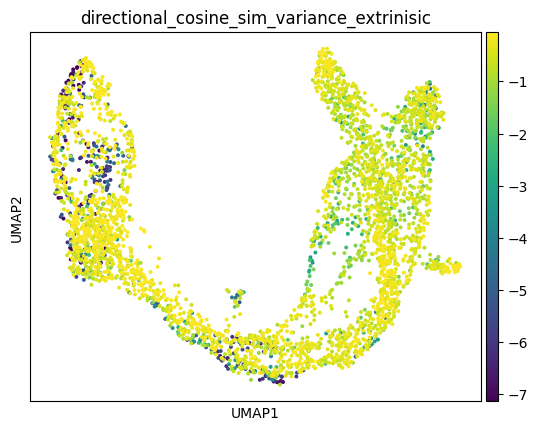

In [5]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance_extrinisic",
    vmin="p1", 
    vmax="p99", 
)

In [6]:
perm_df, _ = vae.get_permutation_scores(labels_key="clusters")
adata.var["permutation_score"] = perm_df.max(1).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


<Axes: xlabel='permutation_score', ylabel='Density'>

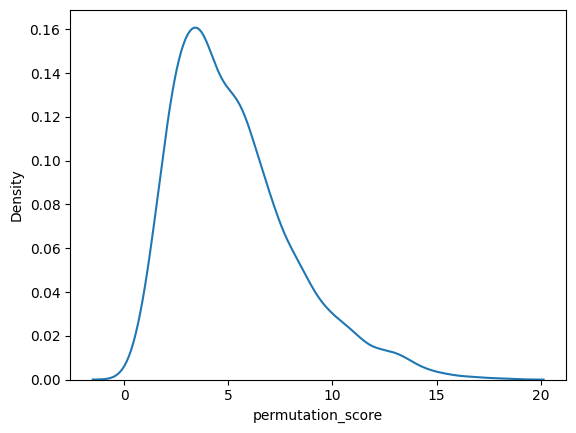

In [7]:
sns.kdeplot(data=adata.var, x="permutation_score")

In [8]:
adata.write_h5ad("velovi_noproc.h5ad")
vae.save("velovi_noproc.pth")